# German Traffic Signs

## Import tools

In [1]:
from os import listdir, makedirs
from glob import glob
from random import shuffle
from shutil import move, copy
import numpy as np
from time import time
import sys

from keras.models import Sequential
from keras.layers import Lambda, ZeroPadding2D, Convolution2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K

from utils import plots
import matplotlib.pyplot as plt
from keras.preprocessing import image
%matplotlib inline

def count_trainables(model): # Compute number of params in a model (the actual number of floats)
    return sum([np.prod(K.get_value(w).shape) for w in model.trainable_weights])

def makedir(path):
    try:
        makedirs(path)
    except OSError:
        pass

Using Theano backend.
Using gpu device 0: GeForce GTX 1070 (CNMeM is disabled, cuDNN 5105)
/opt/conda/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


## Organize the data

### Unzip

In [27]:
!unzip -q data/GTSRB_Final_Training_Images.zip -d data

In [60]:
!unzip -q data/GTSRB_Final_Test_Images.zip -d data

### Inspect

In [59]:
!ls data

GTSRB				 driver_imgs_list.csv.zip
GTSRB_Final_Test_Images.zip	 imgs.zip
GTSRB_Final_Training_Images.zip  sample_submission.csv
dogscats			 sample_submission.csv.zip
dogscats-redux			 statefarm
driver_imgs_list.csv		 traffic-signs


In [61]:
!ls data/GTSRB

Final_Test  Final_Training  Readme-Images-Final-test.txt  Readme-Images.txt


In [32]:
!ls data/GTSRB/Final_Training

Images


In [33]:
!ls data/GTSRB/Final_Training/Images

00000  00004  00008  00012  00016  00020  00024  00028	00032  00036  00040
00001  00005  00009  00013  00017  00021  00025  00029	00033  00037  00041
00002  00006  00010  00014  00018  00022  00026  00030	00034  00038  00042
00003  00007  00011  00015  00019  00023  00027  00031	00035  00039


In [40]:
!ls data/GTSRB/Final_Training/Images/00000 | head

00000_00000.ppm
00000_00001.ppm
00000_00002.ppm
00000_00003.ppm
00000_00004.ppm
00000_00005.ppm
00000_00006.ppm
00000_00007.ppm
00000_00008.ppm
00000_00009.ppm


#### Find max image dimension

In [6]:
import matplotlib.image as mpimg
import os
dims = []
path = "data/GTSRB/Final_Training/Images/"
folders = os.listdir(path)
for folder in folders:
    filenames = os.listdir(path + folder)
    for filename in filenames:
        img = mpimg.imread(path + folder + "/" + filename)
        dims.append(max(img.shape))

In [155]:
max(dims)

243

In [7]:
np.mean(dims)

51.925272258920145

In [162]:
img.shape

(41, 48, 3)

In [8]:
min(dims)

25

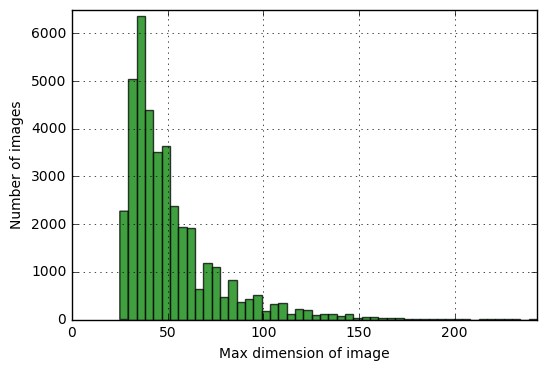

Mean: 51.9252722589
Median: 44.0
Mode: 31
Min: 25
Max: 243


In [32]:
#!/usr/bin/env python
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from scipy.stats import mode

# the histogram of the data
plt.hist(dims, 50, facecolor='green', alpha=0.75)
plt.xlabel('Max dimension of image')
plt.ylabel('Number of images')
plt.axis([0, max(dims), 0, 6500])
plt.grid(True)
plt.show()

print("Mean: {}".format(np.mean(dims)))
print("Median: {}".format(np.median(dims)))
print("Mode: {}".format(mode(dims, axis=None)[0][0]))
print("Min: {}".format(min(dims)))
print("Max: {}".format(max(dims)))

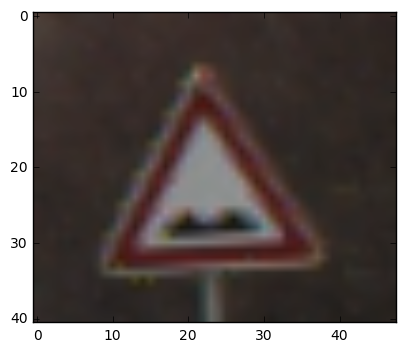

In [193]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(img)

In [205]:
np.rollaxis(img, 2).shape

(3, 41, 48)

### Convert from .ppm to .png

Keras isn't compatible with PPM.

In [46]:
!cd data/GTSRB/Final_Training/Images && mogrify -format png */*.ppm
!cd data/GTSRB/Final_Training/Images && find . -name *.ppm -delete
!cd data/GTSRB/Final_Training/Images && find . -name *.csv -delete

In [65]:
!cd data/GTSRB/Final_Test/Images && mogrify -format png *.ppm
!cd data/GTSRB/Final_Test/Images && rm *.ppm

### Create folders for Keras

In [122]:
# Move *all* training data into a train_all folder before splitting it
!mkdir data/traffic-signs
!cp -r data/GTSRB/Final_Training/Images data/traffic-signs/train-all

# Test folder
!mkdir -p data/traffic-signs/test/unknown
!cp -r data/GTSRB/Final_Test/Images/* data/traffic-signs/test/unknown

!mkdir data/traffic-signs/results

mkdir: cannot create directory 'data/traffic-signs': File exists


In [36]:
path = "data/traffic-signs/"
class_dirs = listdir(path+"train-all")
rel_dirs = ["train/", "valid/", "sample/train/", "sample/valid/"]
dirs = [path+dir_i for dir_i in rel_dirs]
for dir_i in dirs:
    makedir(dir_i)
    for class_dir_i in class_dirs:
        makedir(dir_i+class_dir_i)

### Create a validation set

In [124]:
image_paths = glob(path+"train-all/*/*")
print(image_paths[0])
print(len(image_paths))
print

track_paths = [image_path.split('_')[0] for image_path in image_paths]
tracks = list(set(track_paths))
print(tracks[0])
nb_tracks = len(tracks)
print(nb_tracks)

data/traffic-signs/train-all/00032/00006_00000.png
39209

data/traffic-signs/train-all/00010/00015
1307


In [125]:
cutoff = int(nb_tracks*0.20)
cutoff, nb_tracks

(261, 1307)

In [126]:
shuffle(tracks)
valid_tracks = tracks[:cutoff]
train_tracks = tracks[cutoff:]
len(valid_tracks), len(train_tracks), len(valid_tracks)*30, len(train_tracks)*30

(261, 1046, 7830, 31380)

In [127]:
for track in valid_tracks:
    filenames = glob(track+"_*")
    for filename in filenames:
        copy(filename, filename.replace("train-all", "valid"))
        
for track in train_tracks:
    filenames = glob(track+"_*")
    for filename in filenames:
        copy(filename, filename.replace("train-all", "train"))

### Create a sample

In [130]:
for track in valid_tracks[:2]:
    filenames = glob(track+"_*")
    for filename in filenames:
        copy(filename, filename.replace("train-all", "sample/valid"))

for track in train_tracks[:10]:
    filenames = glob(track+"_*")
    for filename in filenames:
        copy(filename, filename.replace("train-all", "sample/train"))

## Load the data

In [2]:
path = "data/traffic-signs/"
#path = "data/traffic-signs/sample/"
train_path = path + "train/"
valid_path = path + "valid/"
test_path = path + "test/"
results_path = path + "results/"

In [3]:
batch_size = 64
dim = 52 # Mean of max dim of images
#dim = 243
target_size = (dim, dim)

## Define the model

##### vgg16

In [8]:
import numpy as np

from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import Adam
import keras.backend as K

def count_trainables(model): # Compute number of params in a model (the actual number of floats)
    return sum([np.prod(K.get_value(w).shape) for w in model.trainable_weights])

vgg_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32).reshape((3,1,1))
def vgg_preprocess(x):
    x = x - vgg_mean
    return x[:, ::-1] # reverse axis rgb->bgr

def ConvBlock(model, layers, filters):
    for i in range(layers):
        model.add(ZeroPadding2D((1, 1)))
        model.add(Convolution2D(filters, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    return model

def FCBlock(model):
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    return model

def create():
    model = Sequential()
    model.add(Lambda(vgg_preprocess, input_shape=(3,52,52)))

    model = ConvBlock(model, 2, 64)
    model = ConvBlock(model, 2, 128)
    model = ConvBlock(model, 3, 256)
    model = ConvBlock(model, 3, 512)
    model = ConvBlock(model, 3, 512)

    model.add(Flatten())
    model = FCBlock(model)
    model = FCBlock(model)
    model.add(Dense(1000, activation='softmax'))
    
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = create()
print("Trainable parameters: {:,}".format(count_trainables(model)))

/opt/conda/lib/python2.7/site-packages/keras/layers/core.py:577: UserWarning: `output_shape` argument not specified for layer lambda_8 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 3, 52, 52)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


Trainable parameters: 37,694,248


In [ ]:
# Test score: 98.65%
def get_model(nb_class, dropout=False, p=0.5):
    model = Sequential([
        BatchNormalization(axis=1, input_shape=(3, dim, dim)),
        
        Convolution2D(32, 3, 3, activation='relu'),
        BatchNormalization(axis=1),

        Convolution2D(32, 3, 3, activation='relu'),
        MaxPooling2D(),
        BatchNormalization(axis=1),

        Convolution2D(64, 3, 3, activation='relu'),
        BatchNormalization(axis=1),

        Convolution2D(64, 3, 3, activation='relu'),
        MaxPooling2D(),
                
        Flatten(),
        BatchNormalization(),
      
        Dense(512, activation='relu'),
        BatchNormalization()
        ])
    if dropout:
        model.add(Dropout(p))
    model.add(Dense(nb_class, activation='softmax'))
    
    model.compile(Adam(), 'categorical_crossentropy', metrics=['accuracy'])
    return model

model = get_model(43)
print("Trainable parameters: {:,}".format(count_trainables(model)))

##### main

In [5]:
def get_model(nb_class, dropout=False, p=0.5):
    model = Sequential([
        BatchNormalization(axis=1, input_shape=(3, dim, dim)),
        
        Convolution2D(32, 3, 3, activation='relu'),
        BatchNormalization(axis=1),

        Convolution2D(32, 3, 3, activation='relu'),
        MaxPooling2D(),
        BatchNormalization(axis=1),

        Convolution2D(64, 3, 3, activation='relu'),
        BatchNormalization(axis=1),

        Convolution2D(64, 3, 3, activation='relu'),
        MaxPooling2D(),
        BatchNormalization(axis=1),
                
        Flatten(),
      
        Dense(512, activation='relu'),
        BatchNormalization()
        ])
    if dropout:
        model.add(Dropout(p))
    model.add(Dense(nb_class, activation='softmax'))
    
    model.compile(Adam(), 'categorical_crossentropy', metrics=['accuracy'])
    return model

model = get_model(43)
print("Trainable parameters: {:,}".format(count_trainables(model)))

Trainable parameters: 3,379,025


## Find good epoch sequences

#### With Keras's input normalization

In [ ]:
gen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
batches = gen.flow_from_directory(train_path, batch_size=batch_size, target_size=target_size)

val_gen = ImageDataGenerator()
val_batches = val_gen.flow_from_directory(valid_path, batch_size=2*batch_size, target_size=target_size, shuffle=False)

In [5]:
model.optimizer.lr = 0.001
model.fit_generator(batches, batches.nb_sample, nb_epoch=1,
                    validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

Epoch 1/1
31380/31380 [==============================] - 53s - loss: 0.6327 - acc: 0.8108 - val_loss: 1.0896 - val_acc: 0.7163

In [6]:
model.optimizer.lr = 0.01
model.fit_generator(batches, batches.nb_sample, nb_epoch=1,
                    validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

Epoch 1/1
31380/31380 [==============================] - 51s - loss: 0.1035 - acc: 0.9698 - val_loss: 1.1505 - val_acc: 0.7310

In [22]:
ranges = {
    'rotate': np.linspace(0,12,6),
    'width_shift_range': np.linspace(0,0.15,6),
    'height_shift_range': np.linspace(0,0.15,6),
    'channel_shift_range': np.linspace(0,0.05,6),
    'shear_range': np.linspace(0,12,6)}

In [17]:
import numpy as np
from itertools import product

rotation_range = np.linspace(0,12,6)
width_shift_range = np.linspace(0,0.15,6)
height_shift_range = np.linspace(0,0.15,6)
channel_shift_range = np.linspace(0,0.05,6)
shear_range = np.linspace(0,12,6)

param_ranges = [rotation_range, width_shift_range, height_shift_range, channel_shift_range, shear_range]

param_combos = product(*param_ranges)

In [18]:
count = 0
for combo in param_combos:
    count += 1
count

7776

In [11]:
from itertools import product
z = product([1,2],[3,4])

In [9]:
for j in z:
    print j

(1, 3)
(1, 4)
(2, 3)
(2, 4)


In [33]:
print 'hi'

In [ ]:
from scipy.optimize import brute


#### Without Keras's input normalization

keras_output_1484666975.txt

Epoch 30/30
31380/31380 [==============================] - 45s - loss: 7.0884e-04 - acc: 0.9999 - val_loss: 0.0726 - val_acc: 0.9856

In [7]:
gen = ImageDataGenerator()
batches = gen.flow_from_directory(train_path, batch_size=batch_size, target_size=target_size)

val_gen = ImageDataGenerator()
val_batches = val_gen.flow_from_directory(valid_path, batch_size=2*batch_size, target_size=target_size, shuffle=False)

model = get_model(batches.nb_class)
model.load_weights(results_path+"normal-run--1484666975")

Found 31380 images belonging to 43 classes.
Found 7829 images belonging to 43 classes.


In [15]:
model.evaluate_generator(val_batches, val_batches.nb_sample)

[0.072630408878204739, 0.98556648358666499]

In [11]:
model.optimizer.lr = 0.001
model.fit_generator(batches, batches.nb_sample, nb_epoch=1,
                    validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

Epoch 1/1
31380/31380 [==============================] - 46s - loss: 0.2678 - acc: 0.9292 - val_loss: 0.2107 - val_acc: 0.9372

In [12]:
model.optimizer.lr = 0.01
model.fit_generator(batches, batches.nb_sample, nb_epoch=1,
                    validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

Epoch 1/1
31380/31380 [==============================] - 46s - loss: 0.0174 - acc: 0.9959 - val_loss: 0.1909 - val_acc: 0.9442

#### Batchnorm on input

Found 31380 images belonging to 43 classes.
Found 7829 images belonging to 43 classes.
Epoch 1/30
48s - loss: 0.0075 - acc: 0.9980 - val_loss: 0.1561 - val_acc: 0.9576
Epoch 2/30
46s - loss: 0.0077 - acc: 0.9976 - val_loss: 0.1943 - val_acc: 0.9530
Epoch 3/30
45s - loss: 0.0082 - acc: 0.9975 - val_loss: 0.1084 - val_acc: 0.9716
Epoch 4/30
46s - loss: 0.0110 - acc: 0.9968 - val_loss: 0.0973 - val_acc: 0.9775
Epoch 5/30
48s - loss: 0.0065 - acc: 0.9978 - val_loss: 0.0883 - val_acc: 0.9780
Epoch 6/30
48s - loss: 0.0076 - acc: 0.9975 - val_loss: 0.2695 - val_acc: 0.9322
Epoch 7/30
46s - loss: 0.0125 - acc: 0.9962 - val_loss: 0.1494 - val_acc: 0.9687
Epoch 8/30
48s - loss: 0.0029 - acc: 0.9990 - val_loss: 0.0984 - val_acc: 0.9748
Epoch 9/30
48s - loss: 0.0031 - acc: 0.9993 - val_loss: 0.1445 - val_acc: 0.9729
Epoch 10/30
49s - loss: 0.0049 - acc: 0.9983 - val_loss: 0.0989 - val_acc: 0.9771
Epoch 11/30
50s - loss: 0.0117 - acc: 0.9964 - val_loss: 0.0899 - val_acc: 0.9803
Epoch 12/30
51s - lo

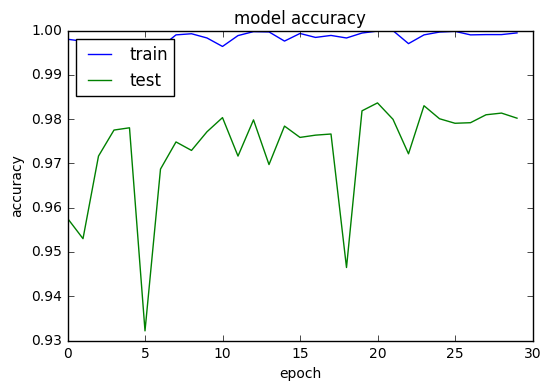

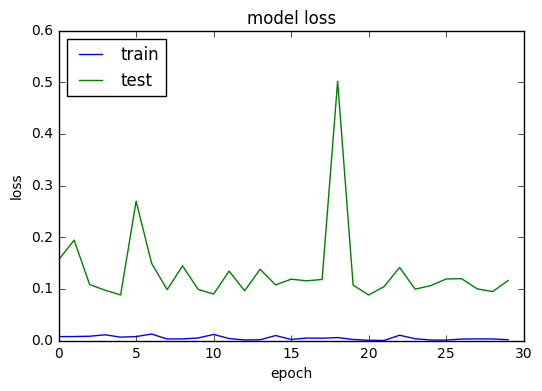

In [44]:
path = "data/traffic-signs/"
#path = "data/traffic-signs/sample/"
train_path = path + "train/"
valid_path = path + "valid/"
test_path = path + "test/"
results_path = path + "results/"

gen = ImageDataGenerator()
batches = gen.flow_from_directory(train_path, batch_size=batch_size, target_size=target_size)

val_gen = ImageDataGenerator()
val_batches = val_gen.flow_from_directory(valid_path, batch_size=2*batch_size, target_size=target_size, shuffle=False)

model.optimizer.lr = 0.001
history = model.fit_generator(batches, batches.nb_sample, nb_epoch=30,
                    validation_data=val_batches, nb_val_samples=val_batches.nb_sample,
                    verbose=2)

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [46]:
max(history.history['val_acc'])

0.9836505300804701

Found 31380 images belonging to 43 classes.
Found 7829 images belonging to 43 classes.
Epoch 1/30
47s - loss: 0.2791 - acc: 0.9263 - val_loss: 0.2912 - val_acc: 0.9158
Epoch 2/30
49s - loss: 0.0219 - acc: 0.9939 - val_loss: 0.2492 - val_acc: 0.9350
Epoch 3/30
49s - loss: 0.0124 - acc: 0.9964 - val_loss: 0.3640 - val_acc: 0.9177
Epoch 4/30
47s - loss: 0.0144 - acc: 0.9959 - val_loss: 0.1817 - val_acc: 0.9485
Epoch 5/30
46s - loss: 0.0148 - acc: 0.9957 - val_loss: 0.1816 - val_acc: 0.9549
Epoch 6/30
49s - loss: 0.0062 - acc: 0.9981 - val_loss: 0.2352 - val_acc: 0.9465
Epoch 7/30
47s - loss: 0.0150 - acc: 0.9957 - val_loss: 0.1250 - val_acc: 0.9687
Epoch 8/30
47s - loss: 0.0012 - acc: 0.9999 - val_loss: 0.0913 - val_acc: 0.9770
Epoch 9/30
47s - loss: 0.0012 - acc: 0.9997 - val_loss: 0.0992 - val_acc: 0.9756
Epoch 10/30
46s - loss: 4.0612e-04 - acc: 1.0000 - val_loss: 0.0941 - val_acc: 0.9771
Epoch 11/30
47s - loss: 1.1972e-04 - acc: 1.0000 - val_loss: 0.0908 - val_acc: 0.9776
Epoch 12/30


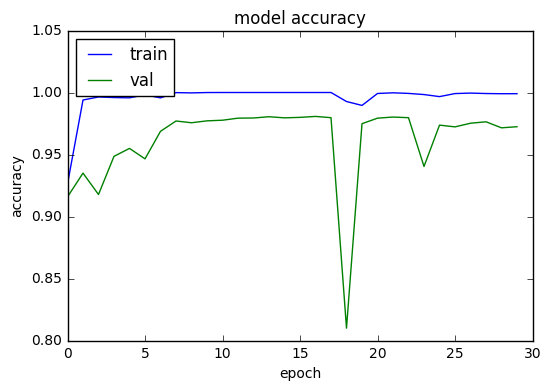

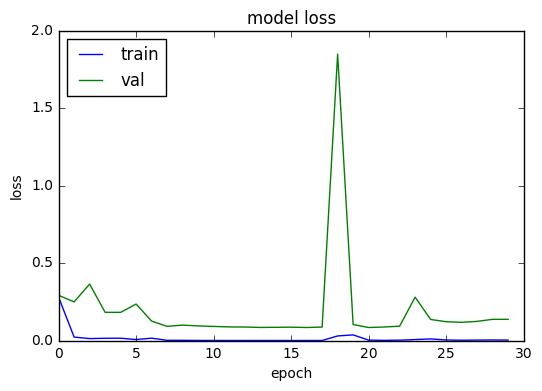

In [49]:
path = "data/traffic-signs/"
#path = "data/traffic-signs/sample/"
train_path = path + "train/"
valid_path = path + "valid/"
test_path = path + "test/"
results_path = path + "results/"

gen = ImageDataGenerator()
batches = gen.flow_from_directory(train_path, batch_size=batch_size, target_size=target_size)

val_gen = ImageDataGenerator()
val_batches = val_gen.flow_from_directory(valid_path, batch_size=2*batch_size, target_size=target_size, shuffle=False)

model = get_model(batches.nb_class)
model.optimizer.lr = 0.001
history = model.fit_generator(batches, batches.nb_sample, nb_epoch=30,
                    validation_data=val_batches, nb_val_samples=val_batches.nb_sample,
                    verbose=2)

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [50]:
max(history.history['val_acc'])

0.98071273470430453

#### Data augmentation

lr = 0.001

|rotate| w_shift| h_shift| c_shift| shear|acc|val_acc|epochs
|-|-|-|-|-|-|-|-|
|10|0.1|0.1|0.05|10|76|90|1
|5|0.1|0.1|0.05|10|76|90|1
|5|0.1|0.1|0.05|10|95|93|2

In [8]:
aug_gen = ImageDataGenerator(rotation_range=5, width_shift_range=0.1, height_shift_range=0.1,
                         shear_range=0.05, channel_shift_range=10)
aug_batches = aug_gen.flow_from_directory(train_path, batch_size=batch_size, target_size=target_size)

val_gen = ImageDataGenerator()
val_batches = val_gen.flow_from_directory(valid_path, batch_size=2*batch_size, target_size=target_size, shuffle=False)

Found 31380 images belonging to 43 classes.
Found 7829 images belonging to 43 classes.


In [9]:
model = get_model(aug_batches.nb_class)
model.optimizer.lr = 0.001
model.fit_generator(aug_batches, aug_batches.nb_sample, nb_epoch=1,
                    validation_data=val_batches, nb_val_samples=val_batches.nb_sample)
model.save_weights(results_path+"data-aug--001.h5")

Epoch 1/1
31380/31380 [==============================] - 51s - loss: 0.8634 - acc: 0.7586 - val_loss: 0.3562 - val_acc: 0.8996

In [10]:
model.optimizer.lr = 0.001
model.fit_generator(aug_batches, aug_batches.nb_sample, nb_epoch=1,
                    validation_data=val_batches, nb_val_samples=val_batches.nb_sample)
model.save_weights(results_path+"data-aug--001.h5")

Epoch 1/1
31380/31380 [==============================] - 50s - loss: 0.1644 - acc: 0.9502 - val_loss: 0.2178 - val_acc: 0.9280

In [17]:
tme = int(time())
sys.stdout = open(results_path+'keras_output_{}.txt'.format(tme), 'a')
model.fit_generator(aug_batches, aug_batches.nb_sample, nb_epoch=20,
                              validation_data=val_batches, nb_val_samples=val_batches.nb_sample)
sys.stdout = sys.__stdout__
model.save_weights(results_path+"data-aug--{}".format(tme))

# tail -f data/traffic-signs/results/keras_output_123.txt

#### Default

In [6]:
gen = ImageDataGenerator()
batches = gen.flow_from_directory(train_path, batch_size=batch_size, target_size=target_size)

val_gen = ImageDataGenerator()
val_batches = val_gen.flow_from_directory(valid_path, batch_size=2*batch_size, target_size=target_size, shuffle=False)

Found 31380 images belonging to 43 classes.
Found 7829 images belonging to 43 classes.


In [7]:
tme = int(time())
sys.stdout = open(results_path+'keras_output_{}.txt'.format(tme), 'a')

model = get_model(batches.nb_class)
model.optimizer.lr = 0.001
model.fit_generator(batches, batches.nb_sample, nb_epoch=30,
                    validation_data=val_batches, nb_val_samples=val_batches.nb_sample)
model.save_weights(results_path+"normal-run--{}".format(tme))

sys.stdout = sys.__stdout__

# tail -f data/traffic-signs/results/keras_output_123.txt

#### Dropout

Found 31380 images belonging to 43 classes.
Found 7829 images belonging to 43 classes.
Epoch 1/30
46s - loss: 0.4187 - acc: 0.8887 - val_loss: 0.2061 - val_acc: 0.9370
Epoch 2/30
46s - loss: 0.0480 - acc: 0.9860 - val_loss: 0.1842 - val_acc: 0.9481
Epoch 3/30
47s - loss: 0.0228 - acc: 0.9941 - val_loss: 0.1781 - val_acc: 0.9527
Epoch 4/30
46s - loss: 0.0181 - acc: 0.9945 - val_loss: 0.1572 - val_acc: 0.9558
Epoch 5/30
50s - loss: 0.0149 - acc: 0.9963 - val_loss: 0.1306 - val_acc: 0.9704
Epoch 6/30
50s - loss: 0.0189 - acc: 0.9947 - val_loss: 0.1301 - val_acc: 0.9665
Epoch 7/30
49s - loss: 0.0108 - acc: 0.9966 - val_loss: 0.0719 - val_acc: 0.9819
Epoch 8/30
45s - loss: 0.0084 - acc: 0.9973 - val_loss: 0.1205 - val_acc: 0.9705
Epoch 9/30
50s - loss: 0.0155 - acc: 0.9953 - val_loss: 0.1356 - val_acc: 0.9678
Epoch 10/30
49s - loss: 0.0143 - acc: 0.9957 - val_loss: 0.0933 - val_acc: 0.9750
Epoch 11/30
51s - loss: 0.0103 - acc: 0.9968 - val_loss: 0.1007 - val_acc: 0.9751
Epoch 12/30
44s - lo

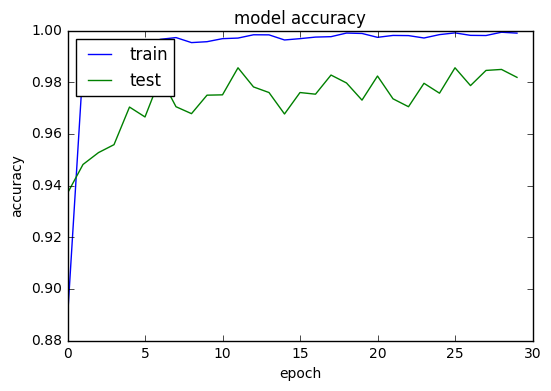

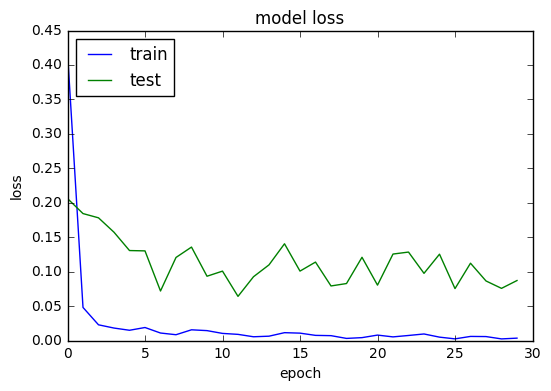

0.985566483594


In [51]:
path = "data/traffic-signs/"
#path = "data/traffic-signs/sample/"
train_path = path + "train/"
valid_path = path + "valid/"
test_path = path + "test/"
results_path = path + "results/"

gen = ImageDataGenerator()
batches = gen.flow_from_directory(train_path, batch_size=batch_size, target_size=target_size)

val_gen = ImageDataGenerator()
val_batches = val_gen.flow_from_directory(valid_path, batch_size=2*batch_size, target_size=target_size, shuffle=False)

model = get_model(batches.nb_class, dropout=True, p=0.5)
model.optimizer.lr = 0.001
history = model.fit_generator(batches, batches.nb_sample, nb_epoch=30,
                    validation_data=val_batches, nb_val_samples=val_batches.nb_sample,
                    verbose=2)

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

print max(history.history['val_acc'])

Found 31380 images belonging to 43 classes.
Found 7829 images belonging to 43 classes.
Epoch 1/30
47s - loss: 0.7755 - acc: 0.8073 - val_loss: 0.1821 - val_acc: 0.9467
Epoch 2/30
48s - loss: 0.0998 - acc: 0.9711 - val_loss: 0.0950 - val_acc: 0.9700
Epoch 3/30
46s - loss: 0.0582 - acc: 0.9824 - val_loss: 0.1183 - val_acc: 0.9674
Epoch 4/30
46s - loss: 0.0403 - acc: 0.9882 - val_loss: 0.0927 - val_acc: 0.9710
Epoch 5/30
47s - loss: 0.0229 - acc: 0.9934 - val_loss: 0.0912 - val_acc: 0.9746
Epoch 6/30
48s - loss: 0.0214 - acc: 0.9940 - val_loss: 0.0982 - val_acc: 0.9710
Epoch 7/30
47s - loss: 0.0294 - acc: 0.9911 - val_loss: 0.0794 - val_acc: 0.9794
Epoch 8/30
49s - loss: 0.0220 - acc: 0.9933 - val_loss: 0.0863 - val_acc: 0.9752
Epoch 9/30
50s - loss: 0.0229 - acc: 0.9926 - val_loss: 0.1020 - val_acc: 0.9742
Epoch 10/30
52s - loss: 0.0192 - acc: 0.9939 - val_loss: 0.0713 - val_acc: 0.9801
Epoch 11/30
50s - loss: 0.0198 - acc: 0.9942 - val_loss: 0.0684 - val_acc: 0.9822
Epoch 12/30
48s - lo

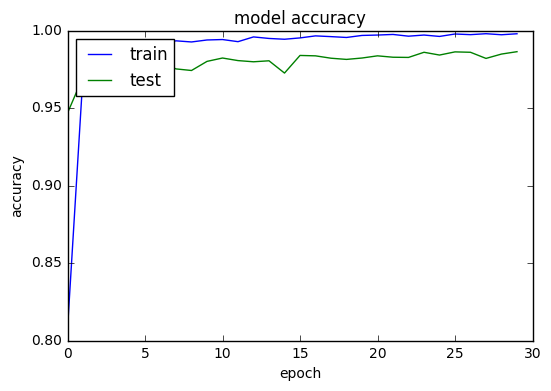

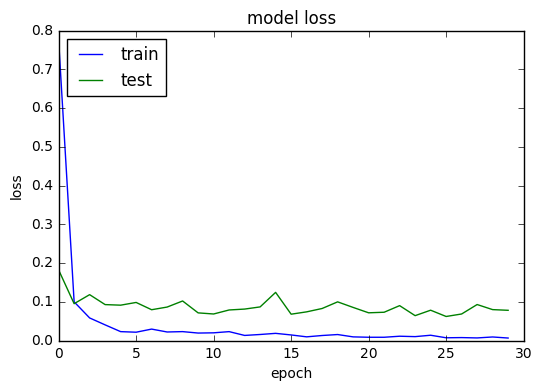

0.986332864989


In [52]:
path = "data/traffic-signs/"
#path = "data/traffic-signs/sample/"
train_path = path + "train/"
valid_path = path + "valid/"
test_path = path + "test/"
results_path = path + "results/"

gen = ImageDataGenerator()
batches = gen.flow_from_directory(train_path, batch_size=batch_size, target_size=target_size)

val_gen = ImageDataGenerator()
val_batches = val_gen.flow_from_directory(valid_path, batch_size=2*batch_size, target_size=target_size, shuffle=False)

model = get_model(batches.nb_class, dropout=True, p=0.75)
model.optimizer.lr = 0.001
history = model.fit_generator(batches, batches.nb_sample, nb_epoch=30,
                    validation_data=val_batches, nb_val_samples=val_batches.nb_sample,
                    verbose=2)

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

print max(history.history['val_acc'])

Found 31380 images belonging to 43 classes.
Found 7829 images belonging to 43 classes.
Epoch 1/30
50s - loss: 2.1151 - acc: 0.5621 - val_loss: 0.3327 - val_acc: 0.9087
Epoch 2/30
48s - loss: 0.4020 - acc: 0.8779 - val_loss: 0.1281 - val_acc: 0.9626
Epoch 3/30
49s - loss: 0.1980 - acc: 0.9402 - val_loss: 0.0957 - val_acc: 0.9725
Epoch 4/30
50s - loss: 0.1401 - acc: 0.9575 - val_loss: 0.0678 - val_acc: 0.9816
Epoch 5/30
46s - loss: 0.1071 - acc: 0.9670 - val_loss: 0.0609 - val_acc: 0.9824
Epoch 6/30
46s - loss: 0.0829 - acc: 0.9750 - val_loss: 0.0652 - val_acc: 0.9798
Epoch 7/30
51s - loss: 0.0767 - acc: 0.9775 - val_loss: 0.0547 - val_acc: 0.9847
Epoch 8/30
52s - loss: 0.0697 - acc: 0.9778 - val_loss: 0.0659 - val_acc: 0.9840
Epoch 9/30
49s - loss: 0.0552 - acc: 0.9830 - val_loss: 0.0495 - val_acc: 0.9875
Epoch 10/30
47s - loss: 0.0550 - acc: 0.9831 - val_loss: 0.0524 - val_acc: 0.9871
Epoch 11/30
45s - loss: 0.0566 - acc: 0.9832 - val_loss: 0.0376 - val_acc: 0.9894
Epoch 12/30
48s - lo

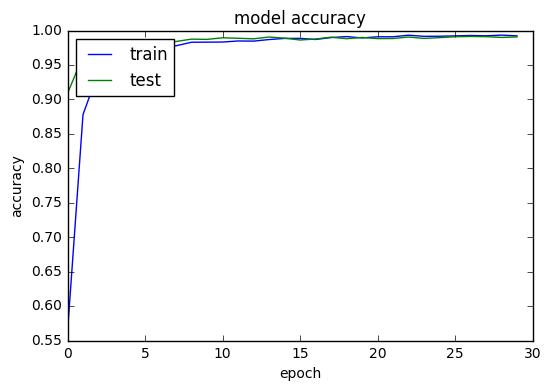

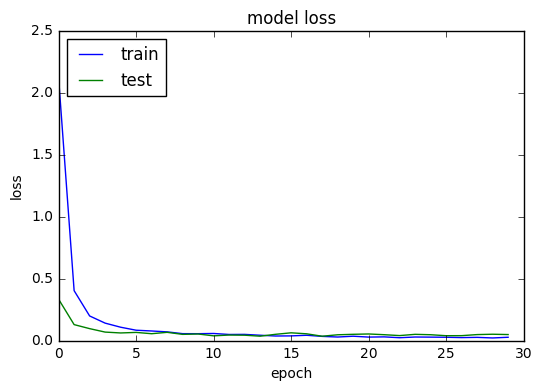

0.991314344105


In [53]:
path = "data/traffic-signs/"
#path = "data/traffic-signs/sample/"
train_path = path + "train/"
valid_path = path + "valid/"
test_path = path + "test/"
results_path = path + "results/"

gen = ImageDataGenerator()
batches = gen.flow_from_directory(train_path, batch_size=batch_size, target_size=target_size)

val_gen = ImageDataGenerator()
val_batches = val_gen.flow_from_directory(valid_path, batch_size=2*batch_size, target_size=target_size, shuffle=False)

model = get_model(batches.nb_class, dropout=True, p=0.90)
model.optimizer.lr = 0.001
history = model.fit_generator(batches, batches.nb_sample, nb_epoch=30,
                    validation_data=val_batches, nb_val_samples=val_batches.nb_sample,
                    verbose=2)

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

print max(history.history['val_acc'])

Found 31380 images belonging to 43 classes.
Found 7829 images belonging to 43 classes.
Epoch 1/30
45s - loss: 8.6469 - acc: 0.0375 - val_loss: 3.5225 - val_acc: 0.0817
Epoch 2/30
46s - loss: 4.1813 - acc: 0.0501 - val_loss: 3.6834 - val_acc: 0.0814
Epoch 3/30
45s - loss: 3.9620 - acc: 0.0551 - val_loss: 3.6091 - val_acc: 0.1231
Epoch 4/30
49s - loss: 3.9292 - acc: 0.0557 - val_loss: 3.5294 - val_acc: 0.0888
Epoch 5/30
46s - loss: 3.8478 - acc: 0.0573 - val_loss: 3.9472 - val_acc: 0.0576
Epoch 6/30
47s - loss: 3.8136 - acc: 0.0580 - val_loss: 3.4170 - val_acc: 0.1139
Epoch 7/30
46s - loss: 3.7803 - acc: 0.0593 - val_loss: 3.3890 - val_acc: 0.1252
Epoch 8/30
45s - loss: 3.7737 - acc: 0.0605 - val_loss: 3.4570 - val_acc: 0.1067
Epoch 9/30
46s - loss: 3.7871 - acc: 0.0594 - val_loss: 3.7881 - val_acc: 0.0976
Epoch 10/30
47s - loss: 3.7404 - acc: 0.0607 - val_loss: 3.4367 - val_acc: 0.0986
Epoch 11/30
46s - loss: 3.7886 - acc: 0.0591 - val_loss: 3.3743 - val_acc: 0.0694
Epoch 12/30
47s - lo

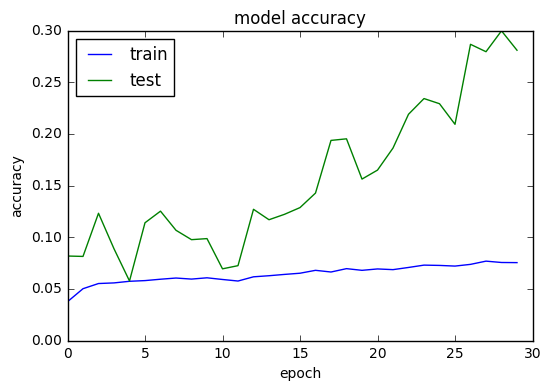

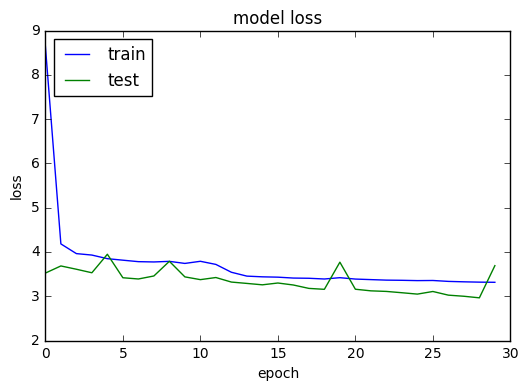

0.299655128369


In [54]:
path = "data/traffic-signs/"
#path = "data/traffic-signs/sample/"
train_path = path + "train/"
valid_path = path + "valid/"
test_path = path + "test/"
results_path = path + "results/"

gen = ImageDataGenerator()
batches = gen.flow_from_directory(train_path, batch_size=batch_size, target_size=target_size)

val_gen = ImageDataGenerator()
val_batches = val_gen.flow_from_directory(valid_path, batch_size=2*batch_size, target_size=target_size, shuffle=False)

model = get_model(batches.nb_class, dropout=True, p=0.99)
model.optimizer.lr = 0.001
history = model.fit_generator(batches, batches.nb_sample, nb_epoch=30,
                    validation_data=val_batches, nb_val_samples=val_batches.nb_sample,
                    verbose=2)

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

print max(history.history['val_acc'])

In [8]:
tme = int(time())
sys.stdout = open(results_path+'dropout--{}.txt'.format(tme), 'a')

model = get_model(batches.nb_class, dropout=True, p=0.25)
model.optimizer.lr = 0.001
model.fit_generator(batches, batches.nb_sample, nb_epoch=30,
                    validation_data=val_batches, nb_val_samples=val_batches.nb_sample)
model.save_weights(results_path+"dropout--{}".format(tme))

sys.stdout = sys.__stdout__

# tail -f data/traffic-signs/results/keras_output_123.txt

In [9]:
tme = int(time())
sys.stdout = open(results_path+'dropout--{}.txt'.format(tme), 'a')

model = get_model(batches.nb_class, dropout=True, p=0.375)
model.optimizer.lr = 0.001
model.fit_generator(batches, batches.nb_sample, nb_epoch=30,
                    validation_data=val_batches, nb_val_samples=val_batches.nb_sample)
model.save_weights(results_path+"dropout--{}".format(tme))

sys.stdout = sys.__stdout__

# tail -f data/traffic-signs/results/keras_output_123.txt

In [7]:
gen = ImageDataGenerator()
batches = gen.flow_from_directory(train_path, batch_size=batch_size, target_size=target_size)

val_gen = ImageDataGenerator()
val_batches = val_gen.flow_from_directory(valid_path, batch_size=2*batch_size, target_size=target_size, shuffle=False)

model = get_model(batches.nb_class, dropout=True, p=0.5)
model.optimizer.lr = 0.001
model.fit_generator(batches, batches.nb_sample, nb_epoch=1,
                    validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

Epoch 1/1
31380/31380 [==============================] - 52s - loss: 0.6396 - acc: 0.8131 - val_loss: 1.0631 - val_acc: 0.7268

In [14]:
model = get_model(batches.nb_class, dropout=True, p=0.25)
model.optimizer.lr = 0.001
model.fit_generator(batches, batches.nb_sample, nb_epoch=1,
                    validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

Epoch 1/1
31380/31380 [==============================] - 49s - loss: 0.3159 - acc: 0.9170 - val_loss: 0.2360 - val_acc: 0.9313

In [15]:
model.optimizer.lr = 0.01
model.fit_generator(batches, batches.nb_sample, nb_epoch=1,
                    validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

Epoch 1/1
31380/31380 [==============================] - 48s - loss: 0.0261 - acc: 0.9930 - val_loss: 0.1486 - val_acc: 0.9568

In [ ]:
model.optimizer.lr = 0.01
model.fit_generator(batches, batches.nb_sample, nb_epoch=1,
                    validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

In [8]:
gen = ImageDataGenerator()
batches = gen.flow_from_directory(train_path, batch_size=batch_size, target_size=target_size)

val_gen = ImageDataGenerator()
val_batches = val_gen.flow_from_directory(valid_path, batch_size=2*batch_size, target_size=target_size, shuffle=False)

model = get_model(batches.nb_class, dropout=True, p=0.25)
model.optimizer.lr = 0.001
model.fit_generator(batches, batches.nb_sample, nb_epoch=1,
                    validation_data=val_batches, nb_val_samples=val_batches.nb_sample)
model.save_weights(results_path+"lesson-3--VGG-style-CNN-bn--no-ft--dropout-25--lr-e-3--epoch-001.h5")

Found 31380 images belonging to 43 classes.
Found 7829 images belonging to 43 classes.
Epoch 1/1
31380/31380 [==============================] - 47s - loss: 0.3037 - acc: 0.9196 - val_loss: 0.2069 - val_acc: 0.9400

In [11]:
model = get_model(batches.nb_class, dropout=True, p=0.25)
model.optimizer.lr = 0.01
model.load_weights(results_path+"lesson-3--VGG-style-CNN-bn--no-ft--dropout-25--lr-e-3--epoch-001.h5")
model.fit_generator(batches, batches.nb_sample, nb_epoch=1,
                    validation_data=val_batches, nb_val_samples=val_batches.nb_sample)
model.save_weights(results_path+"lesson-3--VGG-style-CNN-bn--no-ft--dropout-25--lr-e-3--epoch-002.h5")

Epoch 1/1
31380/31380 [==============================] - 48s - loss: 0.2725 - acc: 0.9279 - val_loss: 0.3271 - val_acc: 0.9332

In [12]:
model = get_model(batches.nb_class, dropout=True, p=0.25)
model.optimizer.lr = 0.1
model.load_weights(results_path+"lesson-3--VGG-style-CNN-bn--no-ft--dropout-25--lr-e-2--epoch-002.h5")
model.fit_generator(batches, batches.nb_sample, nb_epoch=1,
                    validation_data=val_batches, nb_val_samples=val_batches.nb_sample)
model.save_weights(results_path+"lesson-3--VGG-style-CNN-bn--no-ft--dropout-25--lr-e-1--epoch-003.h5")

Epoch 1/1
31380/31380 [==============================] - 47s - loss: 3.1863 - acc: 0.6838 - val_loss: 7.3111 - val_acc: 0.5301

In [ ]:
import time

gen = ImageDataGenerator()
batches = gen.flow_from_directory(train_path, batch_size=batch_size, target_size=target_size)

val_gen = ImageDataGenerator()
val_batches = val_gen.flow_from_directory(valid_path, batch_size=2*batch_size, target_size=target_size, shuffle=False)
###############
model = get_model(batches.nb_class, dropout=True, p=0.25)
model.optimizer.lr = 0.001
model.fit_generator(batches, batches.nb_sample, nb_epoch=1,
                    validation_data=val_batches, nb_val_samples=val_batches.nb_sample)
model.save_weights(results_path+"lesson-3--VGG-style-CNN-bn--no-ft--dropout-25--lr-e-3--epoch-001-002.h5")
###############
time.sleep(0.1)
for _ in range(4):
    model.fit_generator(batches, batches.nb_sample, nb_epoch=4,
                        validation_data=val_batches, nb_val_samples=val_batches.nb_sample)
    time.sleep(0.1)
model.save_weights(results_path+"lesson-3--VGG-style-CNN-bn--no-ft--dropout-25--lr-e-3--epoch-005-002.h5")
###############

Found 31380 images belonging to 43 classes.
Found 7829 images belonging to 43 classes.
Epoch 1/1
 9152/31380 [=======>......................] - ETA: 29s - loss: 0.8470 - acc: 0.7835  

### Dealing with overfitting

#### Augmenting the data

We don't need scale because of the nature of a track.

- ~~Flippings: horizontal, vertical, along some other axis~~
- ~~Croppings~~
- Rotations
- ~~Scales (unneeded here) (aka "zooms")~~
- Shears
- Shifts

##### Inspect augmentations

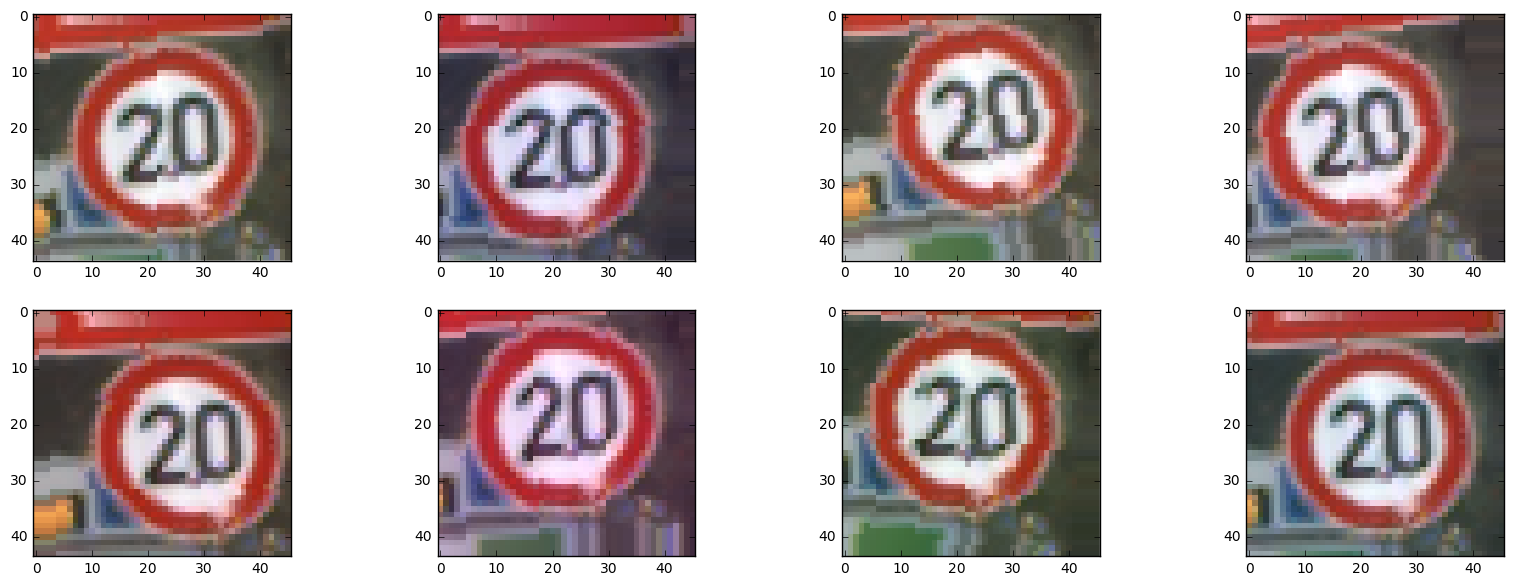

In [67]:
filenames = batches.filenames
gen = image.ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1,
                               shear_range=0.05, channel_shift_range=10, dim_ordering='tf')
img = np.expand_dims(ndimage.imread(train_path + filenames[27]), 0)
aug_iter = gen.flow(img)
aug_imgs = [next(aug_iter)[0].astype(np.uint8) for i in range(8)]
plots(aug_imgs, (20,7), 2)

##### Augment

#### Adding dropout layers

## Train on all the data

### One epoch, 93.51%

In [14]:
batch_size = 64
dim = 52
target_size = (dim, dim)

gen = ImageDataGenerator()
batches = gen.flow_from_directory(path+"train-all/", batch_size=batch_size, target_size=target_size)

Found 39209 images belonging to 43 classes.


In [15]:
model.optimizer.lr = 0.001
model.fit_generator(batches, batches.nb_sample, nb_epoch=1)

Epoch 1/1
39209/39209 [==============================] - 51s - loss: 0.2403 - acc: 0.9355     

### More epochs

In [ ]:
tme = int(time())
stdout_backup = sys.stdout
sys.stdout = open(results_path+'keras_output_{}.txt'.format(tme), 'a')

model = get_model(batches.nb_class)
model.optimizer.lr = 0.001
model.fit_generator(batches, batches.nb_sample, nb_epoch=30,
                    validation_data=val_batches, nb_val_samples=val_batches.nb_sample)
model.save_weights(results_path+"normal-run--{}".format(tme))

sys.stdout = stdout_backup

# tail -f data/traffic-signs/results/keras_output_123.txt

In [51]:
batch_size = 64
dim = 52
target_size = (dim, dim)

gen = ImageDataGenerator()
batches = gen.flow_from_directory(path+"train-all/", batch_size=batch_size, target_size=target_size)

tme = int(time())
nme = "default--30-epochs--{}".format(tme)
stdout_backup = sys.stdout
sys.stdout = open(results_path+nme+".txt", 'a')

models = []
for i in range(6):
    model = get_model(batches.nb_class)
    model.optimizer.lr = 0.001
    model.fit_generator(batches, batches.nb_sample, nb_epoch=30)
    model.save_weights(results_path+"default--30-epochs--{}-{}.h5".format(tme, i))
    models.append(model)

sys.stdout = stdout_backup

## Create an ensemble

In [36]:
nb_class = 43
predsX = []
for i in range(2):
    #gen = ImageDataGenerator()
    #batches = gen.flow_from_directory(test_path, shuffle=False, batch_size=batch_size, target_size=target_size, class_mode=None)
    print batches.filenames[0]
    model = get_model(nb_class)
    model.load_weights(results_path+"default--30-epochs--1484750156-{}.h5".format(i))
    pred = model.predict_generator(batches, batches.nb_sample)
    predsX.append(pred)

unknown/02093.png
unknown/02093.png


In [35]:
q = []
for i in range(2):
    q.append(np.argmax(predsX[i][0]))
q

[12, 38]

In [37]:
q = []
for i in range(2):
    q.append(np.argmax(predsX[i][0]))
q

[2, 30]

In [16]:
nb_class = 43
preds = []
for i in range(6):
    gen = ImageDataGenerator()
    batches = gen.flow_from_directory(test_path, shuffle=False, batch_size=batch_size, target_size=target_size, class_mode=None)
    model = get_model(nb_class)
    model.load_weights(results_path+"default--30-epochs--1484750156-{}.h5".format(i))
    pred = model.predict_generator(batches, batches.nb_sample)
    preds.append(pred)

Found 12630 images belonging to 1 classes.
Found 12630 images belonging to 1 classes.
Found 12630 images belonging to 1 classes.
Found 12630 images belonging to 1 classes.
Found 12630 images belonging to 1 classes.
Found 12630 images belonging to 1 classes.


In [17]:
preds_stack = np.stack(preds)

In [18]:
preds_stack.shape

(6, 12630, 43)

In [19]:
preds_stack[0][0]

array([  7.8660e-18,   2.4142e-14,   9.7083e-20,   3.6674e-18,   6.3246e-20,   5.7322e-14,
         5.3587e-17,   1.9310e-19,   4.1552e-20,   1.1769e-19,   3.0547e-13,   1.0000e+00,
         9.7579e-15,   6.5789e-19,   2.1455e-16,   2.4762e-18,   4.0960e-16,   8.3947e-18,
         8.3066e-14,   1.8497e-18,   2.2753e-18,   8.0825e-13,   1.0441e-21,   7.0881e-22,
         2.1430e-16,   2.6322e-16,   1.6787e-14,   4.5272e-14,   2.7009e-14,   1.7667e-18,
         5.3653e-10,   7.9060e-16,   3.2648e-14,   5.4769e-15,   9.3563e-17,   8.3673e-20,
         2.2039e-21,   5.0836e-19,   1.3588e-19,   5.8814e-23,   1.0019e-18,   4.3566e-17,
         5.8049e-14], dtype=float32)

In [20]:
preds_stack[1][0]

array([  1.4650e-19,   4.4842e-18,   1.6317e-18,   6.0731e-17,   3.1280e-24,   2.9194e-18,
         3.2759e-19,   1.0337e-22,   2.2935e-23,   6.6885e-22,   1.8282e-15,   1.0000e+00,
         1.1830e-18,   3.9942e-21,   2.8531e-15,   6.9813e-24,   8.6737e-17,   1.6083e-20,
         1.9772e-13,   2.4455e-19,   2.6845e-21,   5.7245e-14,   1.2701e-22,   1.2094e-17,
         1.3556e-16,   4.1636e-19,   1.1000e-17,   4.5649e-15,   1.2165e-15,   6.5709e-22,
         4.0447e-17,   3.4518e-18,   1.4556e-17,   6.5016e-19,   2.7653e-17,   6.5832e-18,
         7.1575e-26,   6.7030e-16,   1.5196e-20,   7.9229e-22,   6.7857e-20,   7.4541e-20,
         9.8593e-15], dtype=float32)

In [21]:
avg_preds = preds_stack.mean(axis=0)

In [22]:
labels = [np.argmax(avg_pred) for avg_pred in avg_preds]

In [23]:
q = []
for i in range(6):
    q.append(np.argmax(preds[i][0]))
q

[11, 11, 11, 11, 11, 11]

## Predict labels

In [38]:
gen = ImageDataGenerator()
batches = gen.flow_from_directory(path+"test/", shuffle=False, batch_size=batch_size, target_size=target_size, class_mode=None)

Found 12630 images belonging to 1 classes.


In [39]:
pred = model.predict_generator(batches, batches.nb_sample)

In [40]:
labels = [np.argmax(pred_i) for pred_i in pred]

In [41]:
len(labels)

12630

In [68]:
labels[:10]

[11, 1, 35, 5, 5, 38, 3, 4, 5, 35]

## Prepare the CSV

In [24]:
import csv

In [25]:
batches.filenames[0].split("/")[1].replace("png", "ppm")

'02093.ppm'

In [26]:
filenames = [filename.split("/")[1].replace("png", "ppm") for filename in batches.filenames]

In [27]:
filenames[:3]

['02093.ppm', '05041.ppm', '02466.ppm']

In [28]:
pairs = zip(filenames, labels)
pairs[:3]

[('02093.ppm', 11), ('05041.ppm', 5), ('02466.ppm', 2)]

In [30]:
import time
tme = int(time.time())
with open(results_path+"submission--default--30-epochs--ensemble--{}.csv".format(tme), "w") as csvfile:
    writer = csv.writer(csvfile, delimiter=";")
    for pair in pairs:
        writer.writerow(pair)